In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, DenseNet201, ResNet101V2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
data_location = './data'
CLASS_NAMES = ['covid-19', 'healthy']
IMAGE_SHAPE = (256, 256, 3)
BATCH_SIZE = 8
EPOCHS = 10

DATASET_SIZE = sum([len(files) for r, d, files in os.walk(data_location)])


## Build Dataset

In [3]:
class DataProcessor():
    def __init__(self, data_location):
        self.labeled_dataset = tf.data.Dataset.list_files(f"{data_location}/*/*")
        
    def _get_label(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        return parts[-2] == CLASS_NAMES
    
    def _decode_image(self, img):
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return tf.image.resize(img, [IMAGE_SHAPE[0], IMAGE_SHAPE[1]])
    
    def _pre_proces_images(self, file_path):
        label = self._get_label(file_path)
        img = tf.io.read_file(file_path)
        img = self._decode_image(img)
        return img, label
    
    def prepare_dataset(self):
        self.labeled_dataset = self.labeled_dataset.map(self._pre_proces_images)
        self.labeled_dataset = self.labeled_dataset.cache()
        self.labeled_dataset = self.labeled_dataset.shuffle(buffer_size=10)
        self.labeled_dataset = self.labeled_dataset.repeat()
        self.labeled_dataset = self.labeled_dataset.batch(BATCH_SIZE)
        self.labeled_dataset = self.labeled_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        train_size = int(0.7 * DATASET_SIZE)
        val_size = int(0.15 * DATASET_SIZE)
        test_size = int(0.15 * DATASET_SIZE)
        
        train_dataset = self.labeled_dataset.take(train_size)
        test_dataset = self.labeled_dataset.skip(train_size)
        val_dataset = test_dataset.skip(test_size)
        test_dataset = test_dataset.take(test_size)
        
        return train_dataset, test_dataset, val_dataset

In [4]:
processor = DataProcessor(data_location)
train_dataset, test_dataset, val_dataset = processor.prepare_dataset()

## Build Model

In [5]:
class Wrapper(tf.keras.Model):
    def __init__(self, base_model):
        super(Wrapper, self).__init__()
        
        self.base_model = base_model
        self.average_pooling_layer = AveragePooling2D(name="polling")
        self.flatten = Flatten(name="flatten")
        self.dense = Dense(64, activation="relu")
        self.dropout = Dropout(0.5)
        self.output_layer = Dense(2, activation="softmax")
        
    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.average_pooling_layer(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x)
        output = self.output_layer(x)
        return output

In [6]:
base_learning_rate = 0.0001
steps_per_epoch = DATASET_SIZE//BATCH_SIZE
validation_steps = 20

mobile_net = MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
mobile_net.trainable = False
mobile = Wrapper(mobile_net)
mobile.compile(Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

res_net = ResNet101V2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
res_net.trainable = False
res = Wrapper(res_net)
res.compile(optimizer=Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

dense_net = DenseNet201(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
dense_net.trainable = False
dense = Wrapper(dense_net)
dense.compile(optimizer=Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Users\NikolaVanja\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


## Training

In [7]:
history_mobile = mobile.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=validation_steps)

Epoch 1/10
96/96 [==============================] - 134s 1s/step - loss: 0.1622 - accuracy: 0.9375 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
96/96 [==============================] - 120s 1s/step - loss: 0.0090 - accuracy: 0.9987 - val_loss: 0.9282 - val_accuracy: 0.6000
Epoch 3/10
96/96 [==============================] - 120s 1s/step - loss: 0.0088 - accuracy: 0.9961 - val_loss: 0.4386 - val_accuracy: 0.8250
Epoch 4/10
96/96 [==============================] - 134s 1s/step - loss: 0.0062 - accuracy: 0.9974 - val_loss: 1.9506 - val_accuracy: 0.5125
Epoch 5/10
96/96 [==============================] - 134s 1s/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.3008 - val_accuracy: 0.8938
Epoch 6/10
96/96 [==============================] - 138s 1s/step - loss: 0.0058 - accuracy: 0.9974 - val_loss: 0.9723 - val_accuracy: 0.6062
Epoch 7/10
96/96 [==============================] - 145s 2s/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.8890 - val_accuracy: 0.6250
Epoch

In [8]:
history_resnet = res.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=validation_steps)

Epoch 1/10
96/96 [==============================] - 439s 5s/step - loss: 0.1384 - accuracy: 0.9492 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
96/96 [==============================] - 402s 4s/step - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.1269 - val_accuracy: 0.9812
Epoch 3/10
96/96 [==============================] - 424s 4s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0825 - val_accuracy: 0.9875
Epoch 4/10
96/96 [==============================] - 417s 4s/step - loss: 6.1477e-04 - accuracy: 1.0000 - val_loss: 0.1238 - val_accuracy: 0.9812
Epoch 5/10
96/96 [==============================] - 392s 4s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0899 - val_accuracy: 0.9812
Epoch 6/10
96/96 [==============================] - 389s 4s/step - loss: 5.5733e-04 - accuracy: 1.0000 - val_loss: 0.1079 - val_accuracy: 0.9688
Epoch 7/10
96/96 [==============================] - 391s 4s/step - loss: 9.9143e-04 - accuracy: 1.0000 - val_loss: 0.2806 - val_accuracy: 

In [9]:
history_densenet = dense.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=validation_steps)

Epoch 1/10
96/96 [==============================] - 514s 5s/step - loss: 0.1741 - accuracy: 0.9271 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
96/96 [==============================] - 497s 5s/step - loss: 0.0197 - accuracy: 0.9922 - val_loss: 0.0989 - val_accuracy: 0.9812
Epoch 3/10
96/96 [==============================] - 495s 5s/step - loss: 0.0125 - accuracy: 0.9974 - val_loss: 0.0558 - val_accuracy: 1.0000
Epoch 4/10
96/96 [==============================] - 492s 5s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0486 - val_accuracy: 1.0000
Epoch 5/10
96/96 [==============================] - 528s 5s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0537 - val_accuracy: 0.9875
Epoch 6/10
96/96 [==============================] - 528s 5s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9875
Epoch 7/10
96/96 [==============================] - 517s 5s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0845 - val_accuracy: 0.9688
Epoch

## Ploting History

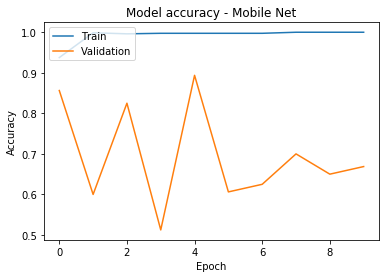

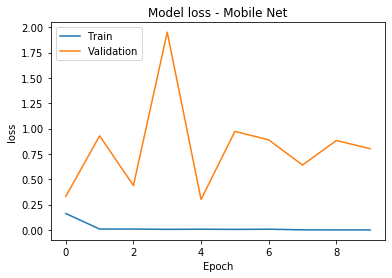

In [10]:
plt.plot(history_mobile.history['accuracy'])
plt.plot(history_mobile.history['val_accuracy'])
plt.title('Model accuracy - Mobile Net')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_mobile.history['loss'])
plt.plot(history_mobile.history['val_loss'])
plt.title('Model loss - Mobile Net')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

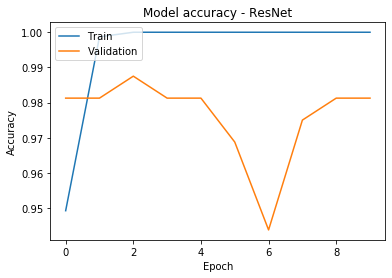

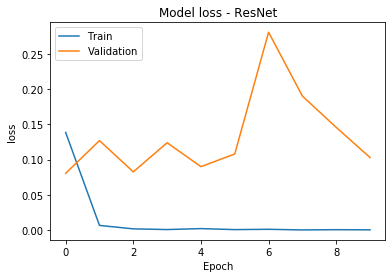

In [11]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Model accuracy - ResNet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Model loss - ResNet')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

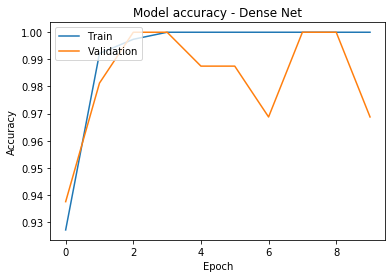

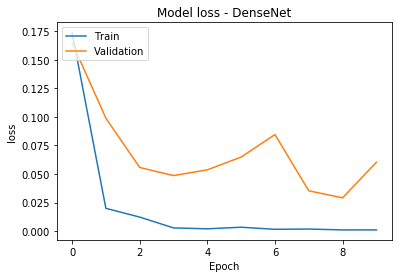

In [12]:
plt.plot(history_densenet.history['accuracy'])
plt.plot(history_densenet.history['val_accuracy'])
plt.title('Model accuracy - Dense Net')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_densenet.history['loss'])
plt.plot(history_densenet.history['val_loss'])
plt.title('Model loss - DenseNet')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluation

In [13]:
loss, accuracy = mobile.evaluate(test_dataset, steps = validation_steps)

print("--------MobileNet---------")
print("Loss: {:.2f}".format(loss))
print("Accuracy: {:.2f}".format(accuracy))
print("---------------------------")

20/20 [==============================] - 6s 292ms/step - loss: 0.7387 - accuracy: 0.6938
--------MobileNet---------
Loss: 0.74
Accuracy: 0.69
---------------------------


In [14]:
loss, accuracy = res.evaluate(test_dataset, steps = validation_steps)

print("--------ResNet---------")
print("Loss: {:.2f}".format(loss))
print("Accuracy: {:.2f}".format(accuracy))
print("---------------------------")

20/20 [==============================] - 39s 2s/step - loss: 0.1114 - accuracy: 0.9750
--------ResNet---------
Loss: 0.11
Accuracy: 0.98
---------------------------


In [15]:
loss, accuracy = dense.evaluate(test_dataset, steps = validation_steps)

print("--------DenseNet---------")
print("Loss: {:.2f}".format(loss))
print("Accuracy: {:.2f}".format(accuracy))
print("---------------------------")

20/20 [==============================] - 33s 2s/step - loss: 0.0668 - accuracy: 0.9625
--------DenseNet---------
Loss: 0.07
Accuracy: 0.96
---------------------------


## Saving Models

In [16]:
tf.saved_model.save(mobile, './models/mobilenet/1')
tf.saved_model.save(res, './models/resnet/1')
tf.saved_model.save(dense, './models/densenet/1')

W0320 13:20:03.692372 19472 deprecation.py:506] From C:\Users\NikolaVanja\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
